In [3]:
import pandas as pd
# Importation des bibliothèques nécessaires
from pyspark.sql import SparkSession
import os
import sys

from dotenv import load_dotenv
from mistralai import Mistral


In [4]:
# Variables
# Paramètres de connexion MySQL
db_url = "jdbc:mysql://mysql-container:3306/wildlens?serverTimezone=UTC"
db_properties = { "user": "root", "password": "root", "driver": "com.mysql.cj.jdbc.Driver" }

In [5]:
# Initialisation de SparkSession
spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", "/installation/mysql-connector-j-9.1.0.jar") \
    .getOrCreate()

25/02/12 19:27:23 WARN Utils: Your hostname, cedric-galaxy-book resolves to a loopback address: 127.0.1.1; using 192.168.1.26 instead (on interface wlo1)
25/02/12 19:27:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/12 19:27:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/12 19:27:24 WARN DependencyUtils: Local jar /installation/mysql-connector-j-9.1.0.jar does not exist, skipping.
25/02/12 19:27:24 INFO SparkContext: Running Spark version 3.5.4
25/02/12 19:27:24 INFO SparkContext: OS info Linux, 6.8.0-51-generic, amd64
25/02/12 19:27:24 INFO SparkContext: Java version 11.0.25
25/02/12 19:27:24 INFO ResourceUtils: ==============================================================
25/02/12 19:27:24 INFO ResourceUtils: No custom resources configured for spark.driver.
25/02/12 19:27:24 INFO ResourceUtils: ==============================================================
25/02/12 

# Gestion des métadonnées des espèces

 Dans un premier temps, nous scannons les dossiers disponibles afin d'en faire un dataframe et réutiliser ces informations.
 Puis nous récupérons les métadonnées depuis l'API Mistral grâce à un prompt optimisé (optimisation du grounding, du prompt engineering)
 un sleep de 3s a été ajouté afin d'éviter de trop spam l'API

In [22]:
folder_all_animals = [d for d in os.listdir("data/OpenAnimalTracks/raw_imgs") if os.path.isdir(os.path.join("data/OpenAnimalTracks/raw_imgs", d))]
df_all_animals = pd.DataFrame(folder_all_animals, columns=["Nom du dossier"])
display(df_all_animals)

,Nom du dossier
0,blackbear
1,mouse
2,horse
3,gray_fox
4,coyote
5,skunk
6,american_mink
7,mountainlion
8,canada_goose
9,rat


In [23]:
import time

# Charger les variables d'environnement
load_dotenv()

# Récupérer la clé API
api_key = os.environ.get("API_KEY")
if not api_key:
    raise ValueError("La clé API n'est pas définie dans les variables d'environnement.")

# Modèle utilisé
model = "open-mistral-nemo"

# Initialiser le client Mistral
client = Mistral(api_key=api_key)

# Définition du fichier CSV
fichier_csv = "data/csv/infos_api_mistral.csv"

# Supprimer le fichier s'il existe déjà
if os.path.exists(fichier_csv):
    os.remove(fichier_csv)

# Liste pour stocker les informations des animaux
donnees_animaux = []

# Récupérer les informations pour chaque animal avec un délai entre les requêtes
for animal in df_all_animals["Nom du dossier"]:
    print(f"🔍 Recherche des informations pour {animal}...")

    # Génération du prompt
    prompt = f"""
    En français, donne-moi les informations suivantes sur {animal} :
    - le nom de l'espèce,
    - la famille,
    - le nom latin,
    - la population estimée (uniquement un nombre, sans texte, sans unité, sans ponctuation sauf le point ou la virgule pour les milliers),
    - la localisation (uniquement le ou les pays, séparés par un espace).
    - la description, une courte phrase décrivant l'animal.

    Attention :
    - Ne mets pas d'explication ou de phrase, uniquement les valeurs demandées.
    - Pour la population, écris uniquement un nombre sans texte. Par exemple : 1000000 au lieu de '1 million d'espèces environ'.
    - Pour la localisation, écris uniquement le ou les pays séparés par un espace.
    - Pour la Description, je souhaite 30 mots grand maximum.
    - Le nom de l'espèce sera systématiquement traduit en français

    Présente les informations sous ce format exact :
    Espèce : <nom de l'espèce>
    Famille : <famille>
    Nom latin : <nom latin>
    Description: <description>
    Population estimée : <population estimée>
    Localisation : <localisation>
    """

    # Appel à l'API Mistral
    try:
        chat_response = client.chat.complete(
            model=model,
            messages=[{"role": "user", "content": prompt}]
        )

        # Extraire la réponse
        reponse = chat_response.choices[0].message.content

        # Parser la réponse pour extraire les valeurs
        informations = {}
        for ligne in reponse.split("\n"):
            if ":" in ligne:
                cle, valeur = ligne.split(":", 1)
                informations[cle.strip()] = valeur.strip()

        # Ajouter les informations à la liste
        donnees_animaux.append(informations)

    except Exception as e:
        print(f"⚠️ Erreur lors de la récupération des infos pour {animal} : {e}")

    # Pause pour éviter d'être banni
    print("⏳ Attente de 3 secondes avant la prochaine requête...")
    time.sleep(3)

# Création du DataFrame
df_animaux = pd.DataFrame(donnees_animaux)

display(df_animaux)

# Sauvegarde dans un CSV
df_animaux.to_csv(fichier_csv, index=False)

print(f"✅ Les informations des animaux ont été enregistrées dans {fichier_csv}.")


🔍 Recherche des informations pour blackbear...
⏳ Attente de 3 secondes avant la prochaine requête...
🔍 Recherche des informations pour mouse...
⏳ Attente de 3 secondes avant la prochaine requête...
🔍 Recherche des informations pour horse...
⏳ Attente de 3 secondes avant la prochaine requête...
🔍 Recherche des informations pour gray_fox...
⏳ Attente de 3 secondes avant la prochaine requête...
🔍 Recherche des informations pour coyote...
⏳ Attente de 3 secondes avant la prochaine requête...
🔍 Recherche des informations pour skunk...
⏳ Attente de 3 secondes avant la prochaine requête...
🔍 Recherche des informations pour american_mink...
⏳ Attente de 3 secondes avant la prochaine requête...
🔍 Recherche des informations pour mountainlion...
⏳ Attente de 3 secondes avant la prochaine requête...
🔍 Recherche des informations pour canada_goose...
⏳ Attente de 3 secondes avant la prochaine requête...
🔍 Recherche des informations pour rat...
⏳ Attente de 3 secondes avant la prochaine requête...
🔍 

,Espèce,Famille,Nom latin,Description,Population estimée,Localisation
0,Ours noir,Ursidae,Ursus americanus,Petit ours noir solitaire et nocturne,900000,Canada États-Unis
1,Souris domestique,Muridés,Mus musculus,Petite souris grise avec des yeux roses et une...,7000000000,Monde entier
2,Cheval,Équidés,Equus ferus caballus,"Mammifère domestiqué, connu pour sa force et s...",58000000,"France, États-Unis, Chine, Russie, Brésil"
3,Renard gris,Canidés,Urocyon cinereoargenteus,Le renard gris est un petit canidé au pelage g...,4000000,États-Unis Mexique
4,Coyote,Canidés,Canis latrans,"Le coyote est un canidé de taille moyenne, aux...",3000000,États-Unis Canada Mexique
5,Skunk,Mustelidae,Mephitis mephitis,Le skunk est un petit mammifère nocturne connu...,32000000,États-Unis Canada
6,Vison d'Amérique,Mustelidae,Neogale vison,Petit mammifère semi-aquatique au pelage brun-...,1000000,Canada États-Unis
7,Puma concolor,Felidae,Puma concolor,"Grand félin aux couleurs de lion de montagne, ...",300000,"Amérique du Nord, Amérique centrale, Amérique ..."
8,Eider à duvet,Anatidae,Somateria mollissima,"Canard marin au plumage blanc et noir, avec un...",1500000,"Canada, Russie, Norvège, Islande, Groenland"
9,Rat domestique,Muridés,Rattus norvegicus,"Petit mammifère rongeur au corps massif, avec ...",600000000,"France, Chine, Inde"


✅ Les informations des animaux ont été enregistrées dans data/csv/infos_api_mistral.csv.


# Gestion des images
Dans un premier temps, nous allons faire une première analyse des images: leurs nombre par espèces (donc, par dossier), leurs tailles moyenne, leurs poid moyen, etc...

,Nom du dossier,Nombre d'images_raw,Largeur Moyenne_raw,Hauteur Moyenne_raw,Nombre d'images_val,Largeur Moyenne_val,Hauteur Moyenne_val,Nombre d'images_train,Largeur Moyenne_train,Hauteur Moyenne_train
0,blackbear,236,981.076271,853.016949,27,414.148148,374.370370,186,447.930108,421.924731
1,mouse,88,768.750000,622.295455,24,109.166667,132.000000,129,152.310078,159.891473
2,horse,56,1273.446429,1089.767857,12,176.250000,153.916667,71,383.521127,340.492958
3,gray_fox,134,1073.880597,819.679104,15,370.666667,353.133333,126,278.182540,283.531746
4,coyote,132,961.363636,958.477273,17,351.058824,340.823529,123,359.276423,405.422764
5,skunk,132,1098.969697,999.159091,14,481.071429,597.785714,122,442.180328,504.950820
6,american_mink,131,1147.305344,877.351145,0,NaN,NaN,0,NaN,NaN
7,mountainlion,106,901.198113,819.292453,0,NaN,NaN,0,NaN,NaN
8,canada_goose,120,982.333333,749.841667,0,NaN,NaN,0,NaN,NaN
9,rat,91,1140.615385,797.560440,21,168.571429,157.904762,116,208.051724,204.767241


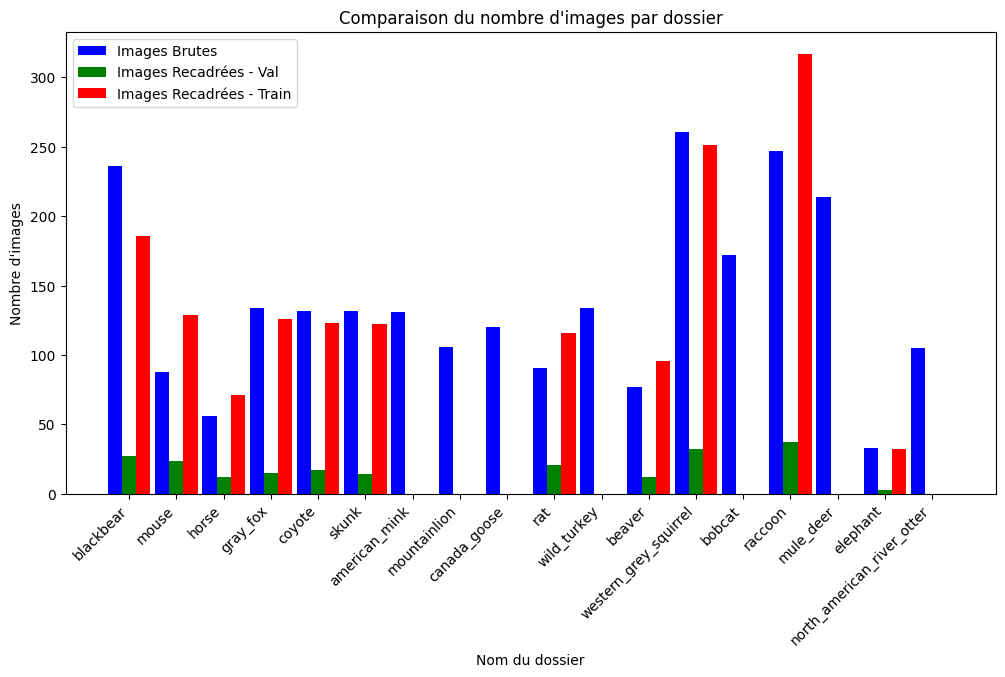

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Définition des chemins des datasets
raw_imgs = "data/OpenAnimalTracks/raw_imgs"
cropped_imgs_val = "data/OpenAnimalTracks/cropped_imgs/val"
cropped_imgs_train = "data/OpenAnimalTracks/cropped_imgs/train"

# Fonction pour récupérer les infos des images d'un dossier (en gérant les dossiers absents)
def get_image_info(folder_path):
    if not os.path.exists(folder_path):  # 📌 Vérifie si le dossier existe
        return 0, None, None  # ⚠️ Si absent → 0 images et tailles nulles

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    num_images = len(image_files)

    if num_images == 0:
        return num_images, None, None  # Aucun fichier image

    widths, heights = [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_width = sum(widths) / len(widths) if widths else None
    avg_height = sum(heights) / len(heights) if heights else None

    return num_images, avg_width, avg_height

# Listes pour stocker les infos
image_data_raw = []
image_data_cropped_val = []
image_data_cropped_train = []

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # 📂 Images brutes
    folder_path_raw = os.path.join(raw_imgs, folder)
    num_images_raw, avg_width_raw, avg_height_raw = get_image_info(folder_path_raw)
    image_data_raw.append([folder, num_images_raw, avg_width_raw, avg_height_raw])

    # ✂️ Images recadrées - validation
    folder_path_val = os.path.join(cropped_imgs_val, folder)
    num_images_val, avg_width_val, avg_height_val = get_image_info(folder_path_val)
    image_data_cropped_val.append([folder, num_images_val, avg_width_val, avg_height_val])

    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(cropped_imgs_train, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data_cropped_train.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
df_raw = pd.DataFrame(image_data_raw, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
df_val = pd.DataFrame(image_data_cropped_val, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
df_train = pd.DataFrame(image_data_cropped_train, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])

# Fusion des DataFrames pour comparaison
df_comparaison = df_raw.merge(df_val, on="Nom du dossier", suffixes=("_raw", "_val"))
df_comparaison = df_comparaison.merge(df_train, on="Nom du dossier", suffixes=("", "_train"))

# Renommer les colonnes pour plus de clarté
df_comparaison.rename(columns={
    "Nombre d'images": "Nombre d'images_train",
    "Largeur Moyenne": "Largeur Moyenne_train",
    "Hauteur Moyenne": "Hauteur Moyenne_train",
}, inplace=True)

# Affichage du DataFrame de comparaison
display(df_comparaison)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = df_comparaison["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, df_comparaison["Nombre d'images_raw"], width=0.3, label="Images Brutes", color='blue')
plt.bar([x + 0.3 for x in x_range], df_comparaison["Nombre d'images_val"], width=0.3, label="Images Recadrées - Val", color='green')
plt.bar([x + 0.6 for x in x_range], df_comparaison["Nombre d'images_train"], width=0.3, label="Images Recadrées - Train", color='red')

plt.xticks([x + 0.3 for x in x_range], x_labels, rotation=45, ha='right')
plt.xlabel("Nom du dossier")
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.show()


In [12]:
# Sauvegarde au format Parquet
cleaned_df.write.parquet("./output/data/nettoye.parquet", mode="overwrite")


AttributeError: 'list' object has no attribute 'write'

In [ ]:
# Écrire les données dans la table MySQL
cleaned_df.write \
    .jdbc(url=db_url, table="Animaux", mode="overwrite", properties=db_properties)
